# Exploring ODF Extraction - BP Data Analysis
## Sam Potter
## Current: 5/1/19

## Path and Imports

In [1]:
import sys
import os

# psfdi
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\Github\psfdi',
                 'C:/Users/potterst1/Desktop/Repositories/Github/psfdi'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/psfdi'])

from psfdi import visualize
from psfdi import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from psfdi import utilities
from psfdi import odf
from psfdi import image_processing as imp
import seaborn as sns
import cv2
import matplotlib

from ipywidgets import *
from scipy import optimize as sciopt
from scipy.stats import beta
from scipy.stats import sem

## Magics

In [2]:
%matplotlib inline

# Visualize Axis Confirmation Images

In [3]:
paper_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\3) Paper\\Sample\\Vertical\\Green'
paper_pic = cv2.imread(os.path.join(paper_data_path, 'planar_angle_0.tiff'), -1)

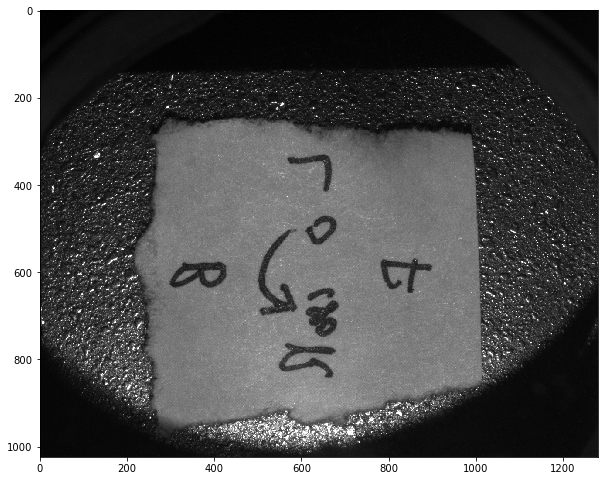

In [4]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(paper_pic, cmap='gray');

# BP Data

## Load Raw Intensity pSFDI Data - 360 Degrees

### Specify file paths

In [5]:
bp_raw_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\2) pSFDI\\Sample\\Vertical\\Green'
bp_standard_path = 'C:\\Users\\potterst1\\Box Sync\\Research\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\4.28.19\\1) Standard\\Standard\\Vertical\\Green'

### Specify spatial frequency and polarizer resolution

In [6]:
sfx_per = 36.4679
polar_res = 4
polar_max = 360
polar_angles = np.arange(0, polar_max, polar_res)

bp_planar = [cv2.imread(os.path.join(bp_raw_path, 'planar_angle_' + str(angle) + '.tiff'), -1)for angle in polar_angles]
bp_planar = np.array(bp_planar)

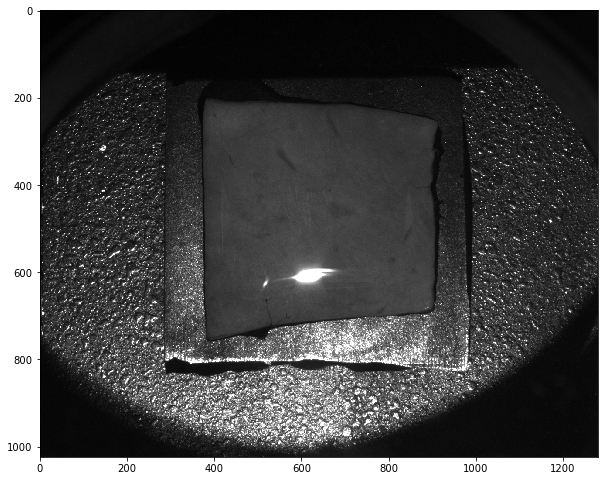

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');

## Crop pSFDI ROI - Doing this manually for now

In [8]:
rowstart, rowstop = 175, 775  # Best: 175, 775
colstart, colstop = 350, 925  # Best: 350, 925

bp_planar = bp_planar[:, rowstart:rowstop, colstart:colstop]

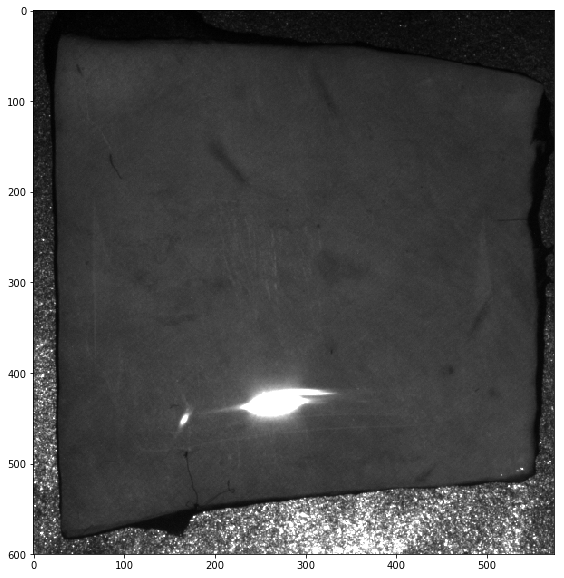

In [9]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');

## Load in SALS data

In [10]:
SALS_data_path = 'C:\\Users\\potterst1\\Box Sync\\Research\\Projects\\IGA DIC pSFDI\\Experimental Data\\2D pSFDI data\\ODF Extraction\\SALS\\BP\\Results\\BP ODF 042919'

SALS_data_dict = fileIO.read_SALS(os.path.join(SALS_data_path, 'SALSA OUT TXT\\BP_ODF_42919_SALSA.txt'))

In [11]:
sals_pd_im = cv2.imread(os.path.join(SALS_data_path, 'Images\\BP_ODF_42919_PrefD.png'), -1)
sals_pd_im = cv2.cvtColor(sals_pd_im, cv2.COLOR_BGR2RGB)

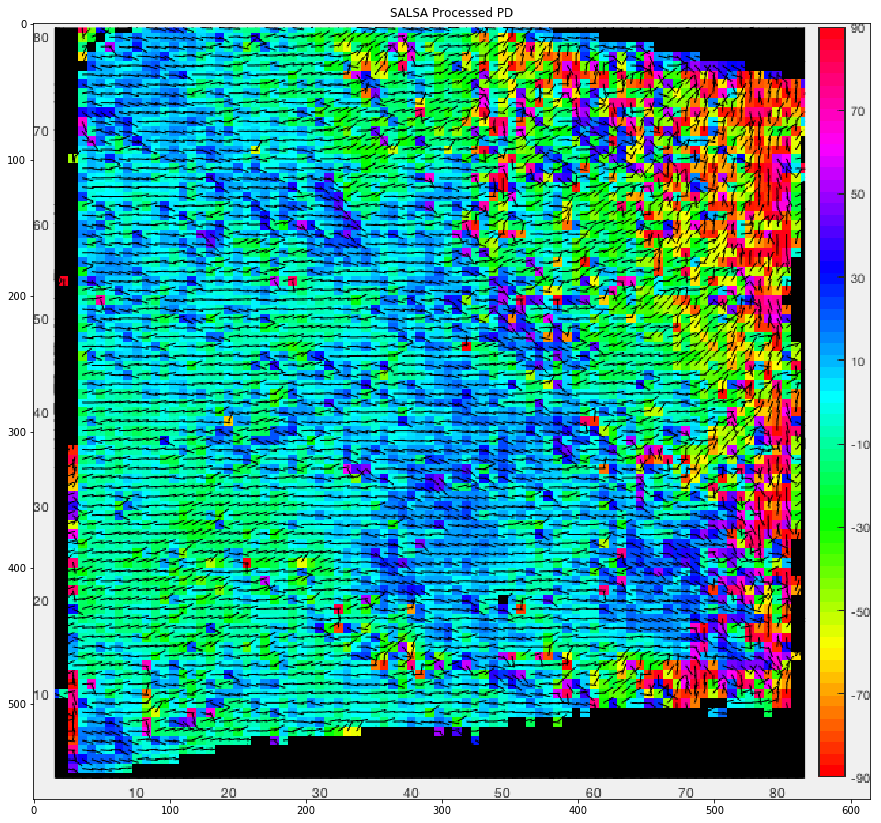

In [12]:
fig = plt.figure(figsize=(15, 15))
plt.title('SALSA Processed PD')
plt.imshow(sals_pd_im);

In [13]:
x = SALS_data_dict['x']
y = SALS_data_dict['y']

PD_2d = SALS_data_dict['PD']
SD_2d = SALS_data_dict['SD']

U = np.cos(np.deg2rad(PD_2d))
V = np.sin(np.deg2rad(PD_2d))

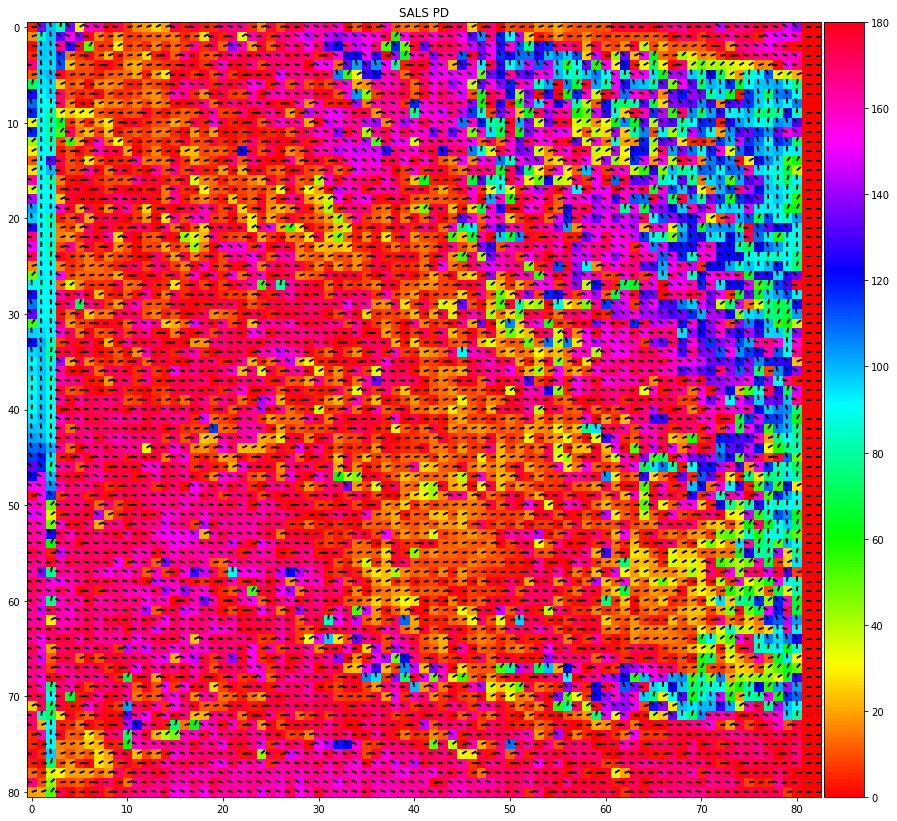

In [14]:
# SALS PD
fig = plt.figure(figsize=(15, 15))
im0 = plt.imshow(PD_2d, cmap='hsv')
plt.quiver(U, V, headlength=0, headaxislength=0);
plt.title('SALS PD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (0, 180);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

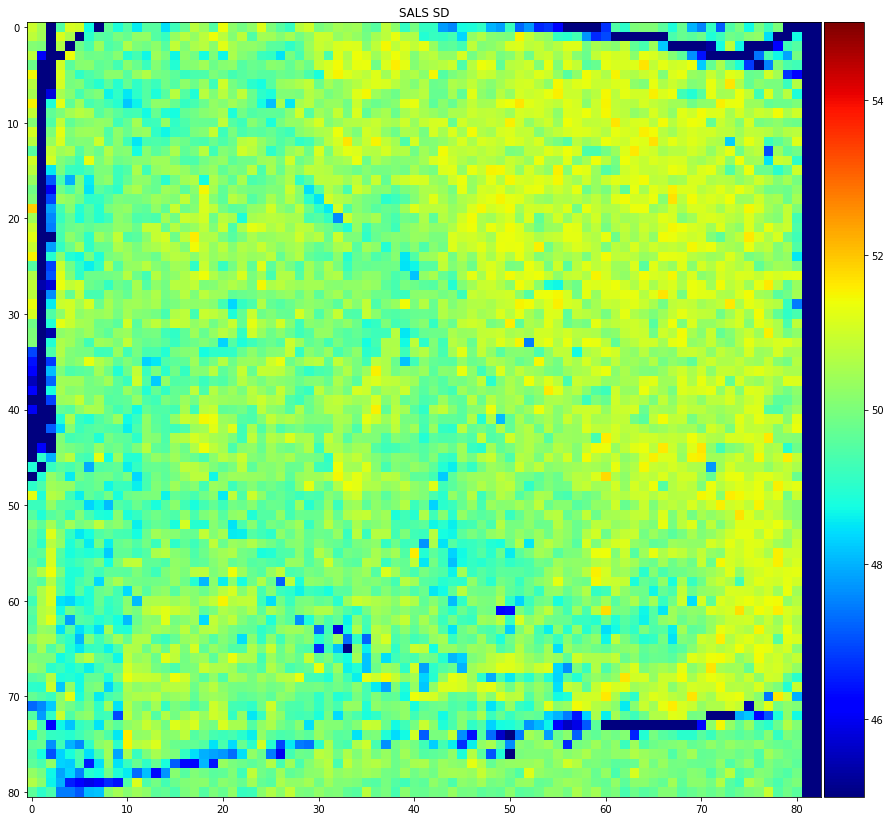

In [15]:
# SALS SD
fig = plt.figure(figsize=(15, 15))
im0 = plt.imshow(SD_2d, cmap='jet')
plt.title('SALS SD')
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
colorlimits = (45, 55);
im0.set_clim(colorlimits)
plt.colorbar(im0, cax=cax);

## Register Images

### Create pSFDI Binary Mask

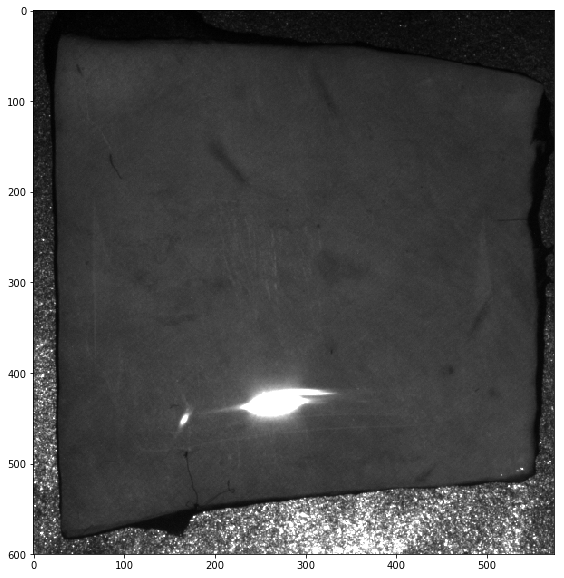

In [16]:
bp_planar_reg = bp_planar[0, :, :]
fig = plt.figure(figsize=(10, 10))
plt.imshow(bp_planar_reg, cmap='gray')
plt.imsave(os.path.join(bp_raw_path, 'cropped_for_mask.png'), bp_planar_reg, cmap='gray')

### View Binary Masks before upscaling

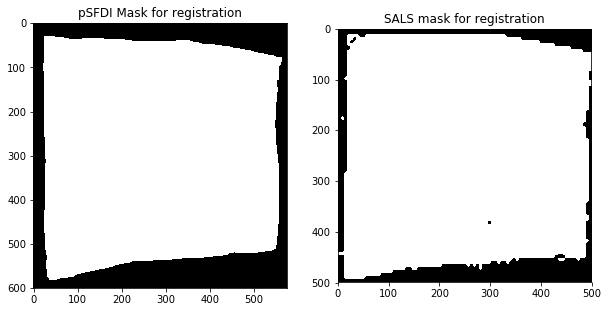

In [17]:
psfdi_mask = cv2.imread(os.path.join(bp_raw_path, 'Mask.tif'), -1)
sals_mask = cv2.imread(os.path.join(SALS_data_path, 'BW_Images\\BP_ODF_42919.png'), -1)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 10))
im0 = ax0.imshow(psfdi_mask, cmap='gray');
ax0.set_title('pSFDI Mask for registration');

im1 = ax1.imshow(sals_mask, cmap='gray')
ax1.set_title('SALS mask for registration');

### Upscale Binary Masks

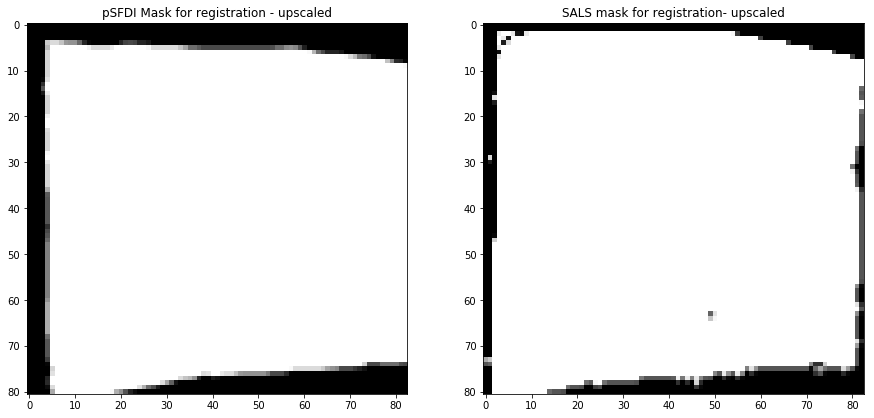

In [18]:
psfdi_mask_upscale = imp.upscale(psfdi_mask, *PD_2d.shape)
sals_mask_upscale = imp.upscale(sals_mask[:, :, 0], *PD_2d.shape)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_upscale, cmap='gray');
ax0.set_title('pSFDI Mask for registration - upscaled');

im1 = ax1.imshow(sals_mask_upscale, cmap='gray')
ax1.set_title('SALS mask for registration- upscaled');

### Register

In [19]:
# Register images
psfdi_mask_registered, warp_data = imp.register(psfdi_mask_upscale.astype(np.uint8), sals_mask_upscale.astype(np.uint8))

print('cc: {}'.format(warp_data['cc']))
print('warp matrix:')
print(warp_data['warp'])

cc: 0.9338342067851787
warp matrix:
[[ 0.9996186  0.0276161  0.1421768]
 [-0.0276161  0.9996186  2.7148695]]


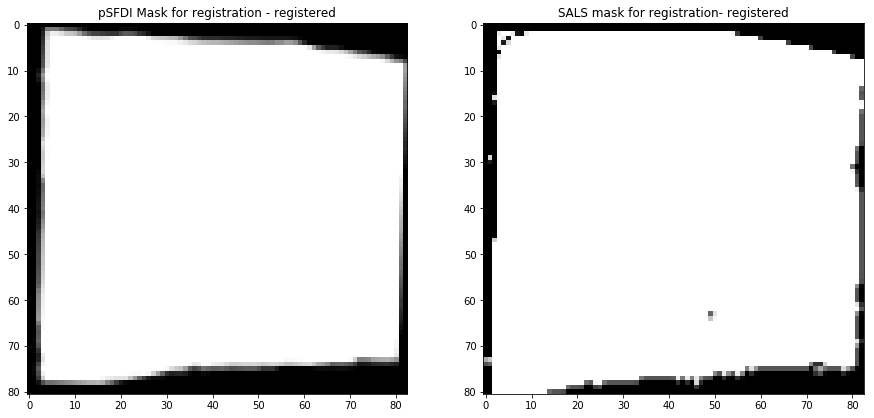

In [20]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15))
im0 = ax0.imshow(psfdi_mask_registered, cmap='gray');
ax0.set_title('pSFDI Mask for registration - registered');

im1 = ax1.imshow(sals_mask_upscale, cmap='gray')
ax1.set_title('SALS mask for registration- registered');

### Upscale and Register all the Planar pSFDI Data

In [21]:
# Upscale
bp_planar_upscale = [imp.upscale(bp_planar[angle, :, :], *PD_2d.shape) for angle in range(len(polar_angles))]
bp_planar_upscale = np.array(bp_planar_upscale)

In [22]:
# Register
bp_planar_registered = [imp.warp(bp_planar_upscale[angle, :, :], warp_data['warp']) for angle in range(len(polar_angles))]
bp_planar_registered = np.array(bp_planar_upscale)

## Feasibility Study - Raw Data

### Set the row and column data for visualization etc

In [23]:
row = 15
col = 15
ydim = SALS_data_dict['PD'].shape[0]

index = col * ydim + (ydim - col)

### Visualize where the point is

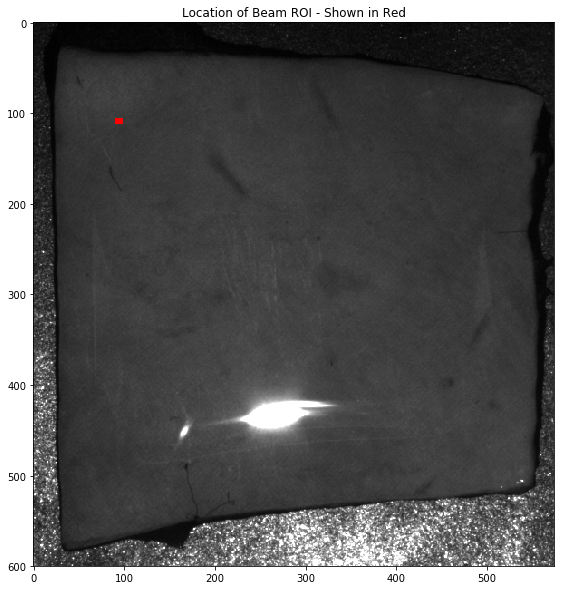

In [24]:
row_step = int(bp_planar.shape[1] / PD_2d.shape[0])
col_step = int(bp_planar.shape[2] / PD_2d.shape[1])

# Get the correct rectangle start indices
psfdi_row = row * row_step
psfdi_col = col * col_step

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(bp_planar[0, :, :], cmap='gray');
rect = patches.Rectangle((psfdi_col, psfdi_row), row_step, col_step, edgecolor='r', facecolor='r')
ax.add_patch(rect);
plt.title('Location of Beam ROI - Shown in Red');

### Get SALS data

In [25]:
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

### Get pSFDI data with roll compensation

In [26]:
roll = 90 // polar_res

bp_data = bp_planar_registered[:, row, col]
bp_data = np.roll(bp_data, roll)

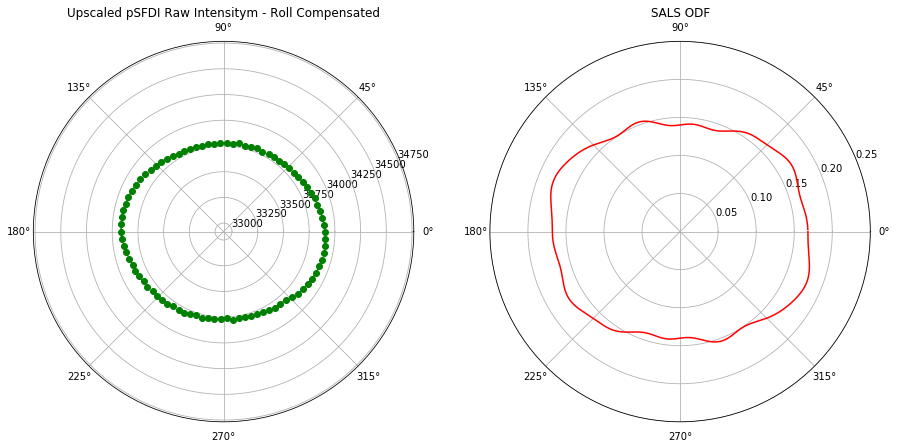

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
ax0.plot(np.deg2rad(polar_angles), bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensitym - Roll Compensated');
ax0.set_ylim([0.975 * np.min(bp_data), 1.025 * np.max(bp_data)])

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.set_ylim([0, 0.25])
ax1.set_title('SALS ODF');

## Fourier Series Fit

### SALS Data

In [28]:
odf_theta = SALS_data_dict['theta'][index, :]
odf_gamma = SALS_data_dict['odf'][index, :]

In [29]:
an, bn, c = odf.fit_fourier(20, odf_gamma, odf_theta)
odf_fsfit = odf.compute_fourier(an, bn, c, odf_theta)

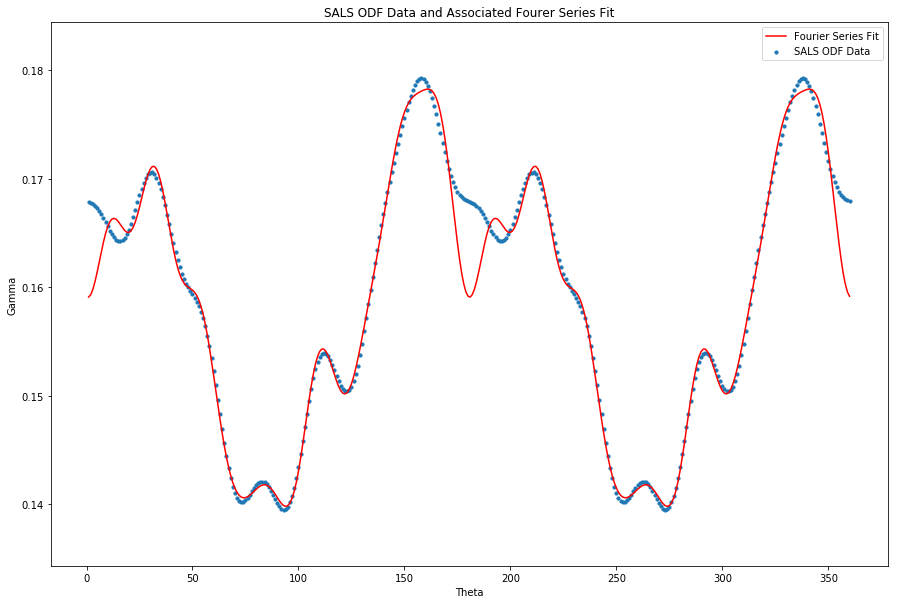

In [30]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, marker='o', s=10, label='SALS ODF Data')
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit');
plt.ylabel('Gamma');
plt.xlabel('Theta');
plt.legend()
plt.title('SALS ODF Data and Associated Fourer Series Fit');

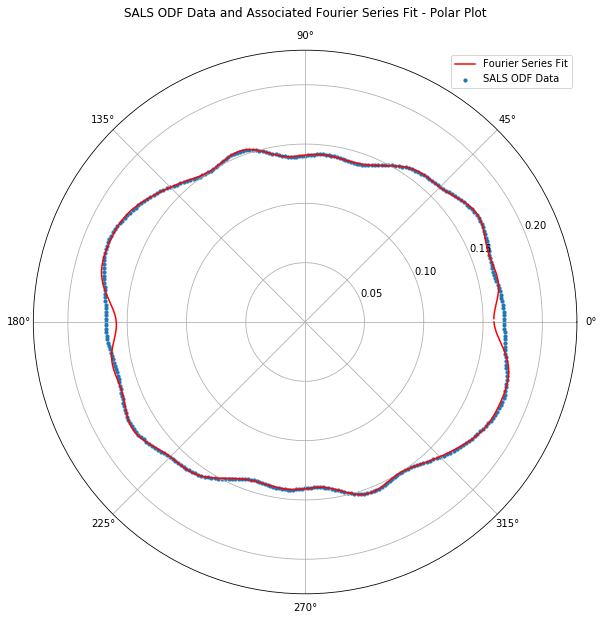

In [31]:
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.legend()
plt.title('SALS ODF Data and Associated Fourier Series Fit - Polar Plot');

## Compute the Primary and Secondary Directions

In [32]:
theta1, theta2 = odf.structural_eigenval_thetas(an[0], bn[0])

In [33]:
print('Theta I (deg): {}'.format(theta1))
print('Theta II (deg): {}'.format(theta2))

Theta I (deg): -4.388509209957465
Theta II (deg): 85.61149079004254


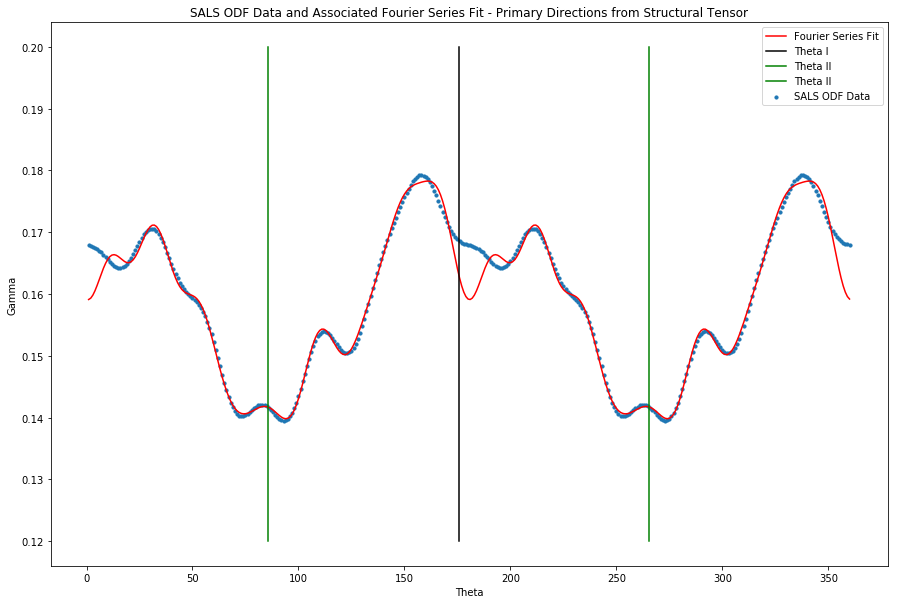

In [34]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(np.rad2deg(odf_theta), odf_gamma, s=10, label='SALS ODF Data');
plt.plot(np.rad2deg(odf_theta), odf_fsfit, color='r', label='Fourier Series Fit')
plt.plot((theta1 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='k', label='Theta I')
plt.plot(theta2 * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.plot((theta2 + 180) * np.ones(len(odf_theta)), np.linspace(0.12, 0.20, len(odf_theta)), color='g', label='Theta II')
plt.xlabel('Theta')
plt.ylabel('Gamma')
plt.legend();
plt.title('SALS ODF Data and Associated Fourier Series Fit - Primary Directions from Structural Tensor');

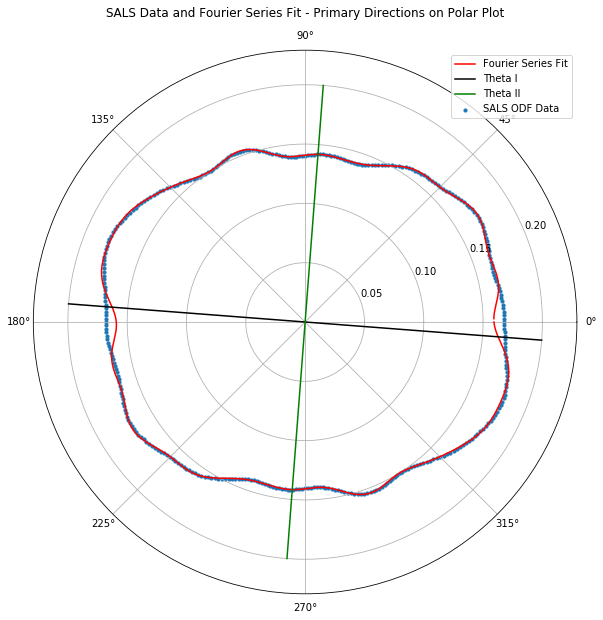

In [35]:
theta1_r = np.deg2rad(theta1)
theta2_r = np.deg2rad(theta2)
fig = plt.figure(figsize=(10, 10))
plt.polar(odf_theta, odf_fsfit, color='r', label='Fourier Series Fit');
plt.scatter(odf_theta, odf_gamma, s=10, label='SALS ODF Data');
plt.polar([theta1_r, theta1_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='k', label='Theta I')
plt.polar([theta2_r, theta2_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='g', label='Theta II')
plt.legend()
plt.title('SALS Data and Fourier Series Fit - Primary Directions on Polar Plot');

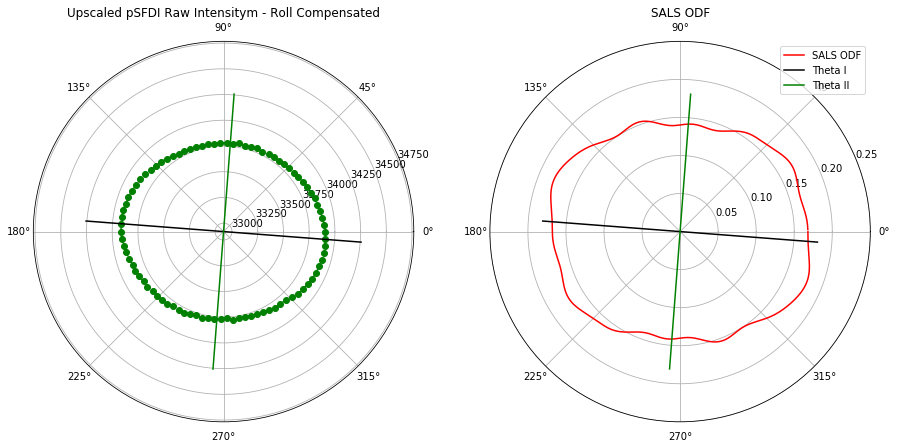

In [46]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 15), subplot_kw=dict(projection='polar'))
ax0.plot(np.deg2rad(polar_angles), bp_data, linestyle='--', marker='o', color='g',
         label='Mean Fiber Intensity');
ax0.set_title('Upscaled pSFDI Raw Intensitym - Roll Compensated');
ax0.set_ylim([0.975 * np.min(bp_data), 1.025 * np.max(bp_data)])
ax0.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='k', label='Theta I')
ax0.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(bp_data), 1.01 * np.max(bp_data)], color='g', label='Theta II')

ax1.plot(odf_theta, odf_gamma, color='r', label='SALS ODF');
ax1.plot([theta1_r, theta1_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='k', label='Theta I')
ax1.plot([theta2_r, theta2_r + np.pi], [1.01 * np.max(odf_gamma), 1.01 * np.max(odf_gamma)], color='g', label='Theta II')
ax1.set_ylim([0, 0.25])
ax1.set_title('SALS ODF');
plt.legend();